# Averaging to approximate inner maximization

In [43]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,2000)
# seed = 4#62
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

1763



# Data preparation

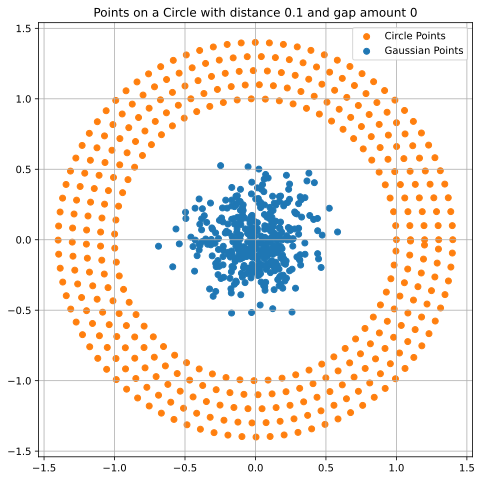

In [44]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

def generate_circle_points(radius, eps, gap_amount, dtype=torch.float32, label_type=torch.int64):
    """
    Generates points on a circle of given radius with a minimum distance between points.

    Args:
        radius (float): Radius of the circle.
        eps (float): Minimum Euclidean distance between points.
        dtype (torch.dtype): Data type for the points.
        label_type (torch.dtype): Data type for the labels.

    Returns:
        tuple: (points, labels) where points are of type dtype and labels are of type label_type.
    """
    points = []
    angle_step = 2 * np.arcsin(eps / (2 * radius))  # Approximation for minimum angle

    angle = 0.0
    while angle < 2 * np.pi - gap_amount*angle_step:
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        points.append((x, y))
        angle += angle_step

    points = torch.tensor(points, dtype=dtype)
    labels = torch.ones(points.size(0), dtype=label_type)  # Assign label 1 to all points

    return points, labels

def generate_gaussian_points(count, mean, std_dev, dtype=torch.float32, label_type=torch.int64):
    """
    Generates Gaussian-distributed points around a given mean with standard deviation.

    Args:
        count (int): Number of points to generate.
        mean (float): Mean value for Gaussian distribution.
        std_dev (float): Standard deviation for Gaussian distribution.
        dtype (torch.dtype): Data type for the points.
        label_type (torch.dtype): Data type for the labels.

    Returns:
        tuple: (points, labels) where points are of type dtype and labels are of type label_type.
    """
    points = torch.normal(mean=mean, std=std_dev, size=(count, 2), dtype=dtype)
    labels = torch.zeros(count, dtype=label_type)  # Assign label 0 to all points

    return points, labels

# Parameters for the circle
radii = [1.,1.1,1.2,1.3,1.4]
epsilon = 0.1
gap_amount = 0

# Generate the dataset for the circle
circle_points_all = torch.zeros(0, dtype=torch.float32)
circle_labels_all = torch.ones(0, dtype=torch.int64)  # Assign label 1 to all points

for radius in radii:
    circle_points, circle_labels = generate_circle_points(radius, epsilon, gap_amount = gap_amount)
    circle_points_all = torch.cat((circle_points_all, circle_points), dim=0)
    circle_labels_all = torch.cat((circle_labels_all, circle_labels), dim=0)        
    

# Generate Gaussian-distributed points
num_gaussian_points = circle_points_all.size(0)
mean = 0.0
std_dev = 0.2
gaussian_points, gaussian_labels = generate_gaussian_points(num_gaussian_points, mean, std_dev)

# Combine datasets
all_points = torch.cat((circle_points_all, gaussian_points), dim=0)
all_labels = torch.cat((circle_labels_all, gaussian_labels), dim=0)



# Plot the points
plt.figure(figsize=(8, 8))
plt.scatter(circle_points_all[:, 0].numpy(), circle_points_all[:, 1].numpy(), color='C1', label='Circle Points')
plt.scatter(gaussian_points[:, 0].numpy(), gaussian_points[:, 1].numpy(), color='C0', label='Gaussian Points')
plt.title(f'Points on a Circle with distance {epsilon} and gap amount {gap_amount}')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid(True)
plt.show()


In [45]:

plotlim = [-2, 2]
subfolder = 'circ'
# data_size = 800
# aa_amount = 4
# adv_budget = 0.2
batch_size = 5

# Create a DataLoader
dataset = TensorDataset(all_points, all_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



# from models.training import create_dataloader
# dataloader, dataloader_viz = create_dataloader('circles_buffer', factor = factor, plotlim = plotlim, random_state = seed, data_size = data_size)


## Model dynamics

In [51]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE, NeuralODEvar

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, time_steps = 10, 10
num_params = 10
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity =  'tanh' #'tanh'
architecture = 'inside' #outside


## Training and generating level sets

In [52]:
#was 200 for 500 points
num_epochs = 300 #00 #number of optimization runs in which the dataset is used for gradient decent

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODEvar(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=time_steps, num_params= num_params, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 


In [53]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, eps = 0, verbose = True) 
trainer_anode.train(dataloader, num_epochs)


Iteration 0/152
Loss: 0.653
Robust Term Loss: 0.000
Accuracy: 0.800

Iteration 10/152
Loss: 0.566
Robust Term Loss: 0.000
Accuracy: 1.000

Iteration 20/152
Loss: 1.113
Robust Term Loss: 0.000
Accuracy: 0.200

Iteration 30/152
Loss: 0.776
Robust Term Loss: 0.000
Accuracy: 0.200

Iteration 40/152
Loss: 0.901
Robust Term Loss: 0.000
Accuracy: 0.600

Iteration 50/152
Loss: 0.644
Robust Term Loss: 0.000
Accuracy: 0.600

Iteration 60/152
Loss: 0.724
Robust Term Loss: 0.000
Accuracy: 0.800

Iteration 70/152
Loss: 0.741
Robust Term Loss: 0.000
Accuracy: 0.600

Iteration 80/152
Loss: 0.648
Robust Term Loss: 0.000
Accuracy: 0.600

Iteration 90/152
Loss: 0.661
Robust Term Loss: 0.000
Accuracy: 0.400

Iteration 100/152
Loss: 0.625
Robust Term Loss: 0.000
Accuracy: 0.800

Iteration 110/152
Loss: 0.794
Robust Term Loss: 0.000
Accuracy: 0.400

Iteration 120/152
Loss: 0.535
Robust Term Loss: 0.000
Accuracy: 0.400

Iteration 130/152
Loss: 0.826
Robust Term Loss: 0.000
Accuracy: 0.200

Iteration 140/15

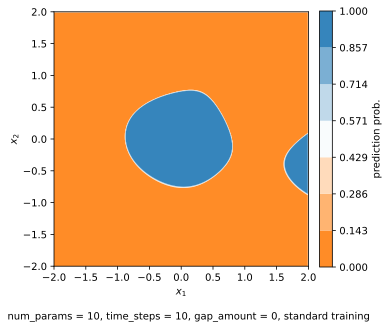

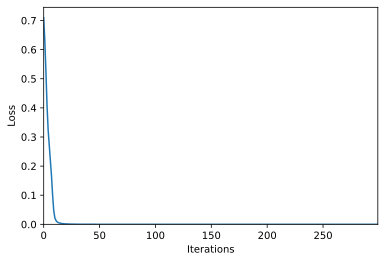

In [54]:
from plots.plots import classification_levelsets
import os
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

footnote = f'{num_params = }, {time_steps = }, {gap_amount = }, standard training'

fig_name_base = os.path.join(subfolder, 'levelsets')
_, ax = classification_levelsets(anode, plotlim = plotlim,
                         footnote=footnote)



plt.savefig(fig_name_base + '.png', bbox_inches='tight',
            dpi=300, format='png', facecolor='white')


plt.show()

plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [55]:
for layer in range(num_params):
    weight = anode.flow.dynamics.fc2_time[layer].weight
    rank = torch.matrix_rank(weight)
    # eigenvalues, _ = torch.eig(weight, eigenvectors=False)
    singular_values = torch.svd(weight).S
    
    # print(f'layer {layer} has rank {rank}')
    # print(f'layer {layer} has eigenvalues \n {eigenvalues}')
    print(f'layer {layer} has eigenvalues \n {singular_values}')
    

layer 0 has eigenvalues 
 tensor([0.9681, 0.0616], grad_fn=<SvdBackward>)
layer 1 has eigenvalues 
 tensor([1.0250, 0.0613], grad_fn=<SvdBackward>)
layer 2 has eigenvalues 
 tensor([1.9375, 0.3079], grad_fn=<SvdBackward>)
layer 3 has eigenvalues 
 tensor([0.7197, 0.2346], grad_fn=<SvdBackward>)
layer 4 has eigenvalues 
 tensor([0.7297, 0.2003], grad_fn=<SvdBackward>)
layer 5 has eigenvalues 
 tensor([1.2895, 0.1420], grad_fn=<SvdBackward>)
layer 6 has eigenvalues 
 tensor([1.5862, 0.1848], grad_fn=<SvdBackward>)
layer 7 has eigenvalues 
 tensor([1.9982, 0.3732], grad_fn=<SvdBackward>)
layer 8 has eigenvalues 
 tensor([2.0273, 0.2476], grad_fn=<SvdBackward>)
layer 9 has eigenvalues 
 tensor([1.5325, 0.2415], grad_fn=<SvdBackward>)
